In [ ]:

import os
import sys
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import logging
from datetime import datetime
import json
import gzip
import urllib.request
from io import StringIO

# ML and stats libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
import joblib

# Bioinformatics libraries
try:
    import pysam
    import HTSeq
except ImportError:
    print("Warning: Some bioinformatics libraries not available. Install with: pip install pysam HTSeq")

warnings.filterwarnings('ignore')

class FungalRNAseqMLPipeline:
    """Complete pipeline for fungal RNA-seq ML analysis"""
    
    def __init__(self, project_dir="yeast_rnaseq_ml_project", threads=8):
        self.project_dir = Path(project_dir)
        self.threads = threads
        
        # Create directory structure
        self.dirs = {
            'data': self.project_dir / 'data',
            'fastq': self.project_dir / 'data' / 'fastq',
            'processed': self.project_dir / 'data' / 'processed',
            'trimmed': self.project_dir / 'data' / 'trimmed',
            'aligned': self.project_dir / 'data' / 'aligned',
            'counts': self.project_dir / 'data' / 'counts',
            'references': self.project_dir / 'references',
            'results': self.project_dir / 'results',
            'ml_results': self.project_dir / 'results' / 'ml_analysis',
            'plots': self.project_dir / 'results' / 'plots',
            'logs': self.project_dir / 'logs'
        }
        
        for dir_path in self.dirs.values():
            dir_path.mkdir(parents=True, exist_ok=True)
        
        # Setup logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(self.dirs['logs'] / 'pipeline.log'),
                logging.StreamHandler(sys.stdout)
            ]
        )
        self.logger = logging.getLogger(__name__)
        
        # Sample metadata
        self.sample_info = {
            'SRR9929264': {'condition': 'Heat', 'replicate': 1, 'paired': True},
            'SRR9929266': {'condition': 'Heat', 'replicate': 2, 'paired': True},
            'SRR14139686': {'condition': 'Osmotic', 'replicate': 1, 'paired': True},
            'SRR14139687': {'condition': 'Osmotic', 'replicate': 2, 'paired': True},
            'SRR14808564': {'condition': 'Starvation', 'replicate': 1, 'paired': True},
            'SRR14808566': {'condition': 'Starvation', 'replicate': 2, 'paired': True},
            'SRR636633': {'condition': 'Oxidative', 'replicate': 1, 'paired': True},
            'SRR636636': {'condition': 'Oxidative', 'replicate': 2, 'paired': True}
        }
        
        # Reference URLs
        self.reference_urls = {
            'genome_fasta': 'ftp://ftp.ensembl.org/pub/release-107/fasta/saccharomyces_cerevisiae/dna/Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa.gz',
            'cdna_fasta': 'ftp://ftp.ensembl.org/pub/release-107/fasta/saccharomyces_cerevisiae/cdna/Saccharomyces_cerevisiae.R64-1-1.cdna.all.fa.gz',
            'gtf': 'ftp://ftp.ensembl.org/pub/release-107/gtf/saccharomyces_cerevisiae/Saccharomyces_cerevisiae.R64-1-1.107.gtf.gz'
        }
        
        self.logger.info(f"Pipeline initialized. Project directory: {self.project_dir}")
    
    def check_dependencies(self):
        """Check if required tools are installed"""
        required_tools = ['fastq-dump', 'salmon', 'fastqc', 'cutadapt', 'multiqc']
        missing_tools = []
        
        for tool in required_tools:
            try:
                subprocess.run([tool, '--version'], capture_output=True, check=True)
                self.logger.info(f"✓ {tool} is available")
            except (subprocess.CalledProcessError, FileNotFoundError):
                missing_tools.append(tool)
                self.logger.warning(f"✗ {tool} is not available")
        
        if missing_tools:
            self.logger.error(f"Missing tools: {missing_tools}")
            self.logger.error("Please install using conda:")
            self.logger.error("conda install -c bioconda sra-tools salmon fastqc cutadapt multiqc")
            return False
        
        return True
    
    def download_references(self):
        """Download reference genome and annotation files"""
        self.logger.info("Downloading reference files...")
        
        for name, url in self.reference_urls.items():
            local_path = self.dirs['references'] / Path(url).name
            decompressed_path = local_path.with_suffix('')
            
            if decompressed_path.exists():
                self.logger.info(f"Reference file {name} already exists")
                continue
            
            self.logger.info(f"Downloading {name} from {url}")
            try:
                urllib.request.urlretrieve(url, local_path)
                
                # Decompress
                with gzip.open(local_path, 'rb') as f_in:
                    with open(decompressed_path, 'wb') as f_out:
                        f_out.write(f_in.read())
                
                local_path.unlink()  # Remove compressed file
                self.logger.info(f"Downloaded and decompressed {name}")
                
            except Exception as e:
                self.logger.error(f"Failed to download {name}: {e}")
                return False
        
        return True
    
    def download_sra_data(self):
        """Download SRA data using fastq-dump"""
        self.logger.info("Downloading SRA data...")
        
        for srr, info in self.sample_info.items():
            fastq_files = [
                self.dirs['fastq'] / f"{srr}_1.fastq",
                self.dirs['fastq'] / f"{srr}_2.fastq" if info['paired'] else None
            ]
            
            if all(f.exists() for f in fastq_files if f is not None):
                self.logger.info(f"FASTQ files for {srr} already exist")
                continue
            
            self.logger.info(f"Downloading {srr}...")
            cmd = [
                'fastq-dump',
                '--outdir', str(self.dirs['fastq']),
                '--split-files' if info['paired'] else '--split-spot',
                '--skip-technical',
                '--readids',
                '--read-filter', 'pass',
                '--dumpbase',
                '--clip',
                srr
            ]
            
            try:
                subprocess.run(cmd, check=True, capture_output=True, text=True)
                self.logger.info(f"Successfully downloaded {srr}")
            except subprocess.CalledProcessError as e:
                self.logger.error(f"Failed to download {srr}: {e}")
                return False
        
        return True
    
    def quality_control(self):
        """Run FastQC on all FASTQ files"""
        self.logger.info("Running quality control...")
        
        qc_dir = self.dirs['results'] / 'qc'
        qc_dir.mkdir(exist_ok=True)
        
        fastq_files = list(self.dirs['fastq'].glob('*.fastq'))
        
        if not fastq_files:
            self.logger.error("No FASTQ files found for QC")
            return False
        
        cmd = [
            'fastqc',
            '-t', str(self.threads),
            '-o', str(qc_dir)
        ] + [str(f) for f in fastq_files]
        
        try:
            subprocess.run(cmd, check=True)
            self.logger.info("FastQC completed successfully")
            
            # Run MultiQC to aggregate results
            subprocess.run(['multiqc', str(qc_dir), '-o', str(qc_dir)], check=True)
            self.logger.info("MultiQC completed successfully")
            
        except subprocess.CalledProcessError as e:
            self.logger.error(f"Quality control failed: {e}")
            return False
        
        return True
    
    def trim_adapters(self):
        """Trim adapters and low-quality sequences"""
        self.logger.info("Trimming adapters...")
        
        for srr, info in self.sample_info.items():
            if info['paired']:
                input_files = [
                    self.dirs['fastq'] / f"{srr}_1.fastq",
                    self.dirs['fastq'] / f"{srr}_2.fastq"
                ]
                output_files = [
                    self.dirs['trimmed'] / f"{srr}_1.trimmed.fastq",
                    self.dirs['trimmed'] / f"{srr}_2.trimmed.fastq"
                ]
            else:
                input_files = [self.dirs['fastq'] / f"{srr}.fastq"]
                output_files = [self.dirs['trimmed'] / f"{srr}.trimmed.fastq"]
            
            if all(f.exists() for f in output_files):
                self.logger.info(f"Trimmed files for {srr} already exist")
                continue
            
            self.logger.info(f"Trimming {srr}...")
            
            if info['paired']:
                cmd = [
                    'cutadapt',
                    '-j', str(self.threads),
                    '-a', 'AGATCGGAAGAGC',  # TruSeq adapter
                    '-A', 'AGATCGGAAGAGC',
                    '-q', '20',
                    '-m', '20',
                    '--max-n', '0.1',
                    '-o', str(output_files[0]),
                    '-p', str(output_files[1]),
                    str(input_files[0]),
                    str(input_files[1])
                ]
            else:
                cmd = [
                    'cutadapt',
                    '-j', str(self.threads),
                    '-a', 'AGATCGGAAGAGC',
                    '-q', '20',
                    '-m', '20',
                    '--max-n', '0.1',
                    '-o', str(output_files[0]),
                    str(input_files[0])
                ]
            
            try:
                result = subprocess.run(cmd, check=True, capture_output=True, text=True)
                self.logger.info(f"Successfully trimmed {srr}")
            except subprocess.CalledProcessError as e:
                self.logger.error(f"Failed to trim {srr}: {e}")
                return False
        
        return True
    
    def build_salmon_index(self):
        """Build Salmon index for quantification"""
        self.logger.info("Building Salmon index...")
        
        index_dir = self.dirs['references'] / 'salmon_index'
        cdna_fasta = self.dirs['references'] / 'Saccharomyces_cerevisiae.R64-1-1.cdna.all.fa'
        
        if index_dir.exists():
            self.logger.info("Salmon index already exists")
            return True
        
        cmd = [
            'salmon', 'index',
            '-t', str(cdna_fasta),
            '-i', str(index_dir),
            '--type', 'quasi',
            '-k', '31'
        ]
        
        try:
            subprocess.run(cmd, check=True, capture_output=True, text=True)
            self.logger.info("Salmon index built successfully")
            return True
        except subprocess.CalledProcessError as e:
            self.logger.error(f"Failed to build Salmon index: {e}")
            return False
    
    def quantify_expression(self):
        """Quantify gene expression with Salmon"""
        self.logger.info("Quantifying gene expression...")
        
        index_dir = self.dirs['references'] / 'salmon_index'
        
        for srr, info in self.sample_info.items():
            sample_name = f"{info['condition']}_Rep{info['replicate']}"
            output_dir = self.dirs['counts'] / sample_name
            
            if (output_dir / 'quant.sf').exists():
                self.logger.info(f"Quantification for {sample_name} already exists")
                continue
            
            if info['paired']:
                read1 = self.dirs['trimmed'] / f"{srr}_1.trimmed.fastq"
                read2 = self.dirs['trimmed'] / f"{srr}_2.trimmed.fastq"
                
                cmd = [
                    'salmon', 'quant',
                    '-i', str(index_dir),
                    '-l', 'A',  # Auto-detect library type
                    '-1', str(read1),
                    '-2', str(read2),
                    '-p', str(self.threads),
                    '--validateMappings',
                    '--gcBias',
                    '--seqBias',
                    '-o', str(output_dir)
                ]
            else:
                read_file = self.dirs['trimmed'] / f"{srr}.trimmed.fastq"
                cmd = [
                    'salmon', 'quant',
                    '-i', str(index_dir),
                    '-l', 'A',
                    '-r', str(read_file),
                    '-p', str(self.threads),
                    '--validateMappings',
                    '--gcBias',
                    '--seqBias',
                    '-o', str(output_dir)
                ]
            
            self.logger.info(f"Quantifying {sample_name}...")
            try:
                subprocess.run(cmd, check=True, capture_output=True, text=True)
                self.logger.info(f"Successfully quantified {sample_name}")
            except subprocess.CalledProcessError as e:
                self.logger.error(f"Failed to quantify {sample_name}: {e}")
                return False
        
        return True
    
    def prepare_count_matrix(self):
        """Prepare count matrix from Salmon output"""
        self.logger.info("Preparing count matrix...")
        
        # Read transcript-to-gene mapping from GTF
        gtf_file = self.dirs['references'] / 'Saccharomyces_cerevisiae.R64-1-1.107.gtf'
        tx_to_gene = self.parse_gtf_for_tx_gene_mapping(gtf_file)
        
        # Collect all quantification results
        sample_data = {}
        
        for srr, info in self.sample_info.items():
            sample_name = f"{info['condition']}_Rep{info['replicate']}"
            quant_file = self.dirs['counts'] / sample_name / 'quant.sf'
            
            if not quant_file.exists():
                self.logger.error(f"Quantification file not found for {sample_name}")
                return None
            
            # Read Salmon output
            df = pd.read_csv(quant_file, sep='\t')
            sample_data[sample_name] = df.set_index('Name')
        
        # Create transcript-level matrix
        transcript_tpm = pd.DataFrame({sample: data['TPM'] for sample, data in sample_data.items()})
        transcript_counts = pd.DataFrame({sample: data['NumReads'] for sample, data in sample_data.items()})
        
        # Aggregate to gene level
        gene_tpm = self.aggregate_transcripts_to_genes(transcript_tpm, tx_to_gene)
        gene_counts = self.aggregate_transcripts_to_genes(transcript_counts, tx_to_gene)
        
        # Save matrices
        gene_tpm.to_csv(self.dirs['counts'] / 'gene_tpm_matrix.csv')
        gene_counts.to_csv(self.dirs['counts'] / 'gene_counts_matrix.csv')
        
        # Create metadata
        metadata = pd.DataFrame([
            {
                'sample': f"{info['condition']}_Rep{info['replicate']}",
                'condition': info['condition'],
                'replicate': info['replicate'],
                'srr': srr
            }
            for srr, info in self.sample_info.items()
        ])
        
        metadata.to_csv(self.dirs['counts'] / 'sample_metadata.csv', index=False)
        
        self.logger.info("Count matrices prepared successfully")
        return gene_tpm, gene_counts, metadata
    
    def parse_gtf_for_tx_gene_mapping(self, gtf_file):
        """Parse GTF file to get transcript-to-gene mapping"""
        tx_to_gene = {}
        
        with open(gtf_file, 'r') as f:
            for line in f:
                if line.startswith('#'):
                    continue
                
                fields = line.strip().split('\t')
                if len(fields) < 9 or fields[2] != 'transcript':
                    continue
                
                attributes = fields[8]
                
                # Parse attributes
                gene_id = None
                transcript_id = None
                
                for attr in attributes.split(';'):
                    attr = attr.strip()
                    if attr.startswith('gene_id'):
                        gene_id = attr.split('"')[1]
                    elif attr.startswith('transcript_id'):
                        transcript_id = attr.split('"')[1]
                
                if gene_id and transcript_id:
                    tx_to_gene[transcript_id] = gene_id
        
        return tx_to_gene
    
    def aggregate_transcripts_to_genes(self, transcript_matrix, tx_to_gene):
        """Aggregate transcript-level data to gene level"""
        gene_matrix = {}
        
        for transcript_id, values in transcript_matrix.iterrows():
            if transcript_id in tx_to_gene:
                gene_id = tx_to_gene[transcript_id]
                if gene_id not in gene_matrix:
                    gene_matrix[gene_id] = values
                else:
                    gene_matrix[gene_id] += values
        
        return pd.DataFrame(gene_matrix).T
    
    def differential_expression_analysis(self, gene_counts, metadata):
        """Perform differential expression analysis using simple statistical methods"""
        self.logger.info("Performing differential expression analysis...")
        
        # Simple fold-change and t-test based analysis
        conditions = metadata['condition'].unique()
        
        # Normalize counts (simple TPM-like normalization)
        gene_lengths = gene_counts.sum(axis=1)  # Approximate gene length
        normalized_counts = gene_counts.div(gene_lengths, axis=0) * 1e6
        
        # Log transform
        log_counts = np.log2(normalized_counts + 1)
        
        # Perform pairwise comparisons
        de_results = {}
        
        for condition in conditions:
            if condition == 'Control':  # Skip if control condition exists
                continue
                
            condition_samples = metadata[metadata['condition'] == condition]['sample'].values
            other_samples = metadata[metadata['condition'] != condition]['sample'].values
            
            if len(other_samples) == 0:
                continue
            
            condition_expr = log_counts[condition_samples].mean(axis=1)
            other_expr = log_counts[other_samples].mean(axis=1)
            
            fold_change = condition_expr - other_expr
            
            # Simple statistical test (t-test approximation)
            condition_var = log_counts[condition_samples].var(axis=1, ddof=1)
            other_var = log_counts[other_samples].var(axis=1, ddof=1)
            
            # Handle division by zero
            condition_var = condition_var.fillna(0.01)
            other_var = other_var.fillna(0.01)
            
            pooled_se = np.sqrt((condition_var / len(condition_samples)) + 
                               (other_var / len(other_samples)))
            
            t_stat = fold_change / (pooled_se + 1e-8)  # Add small value to avoid division by zero
            
            # Create results dataframe
            results_df = pd.DataFrame({
                'gene': fold_change.index,
                'log2FoldChange': fold_change,
                'condition_mean': condition_expr,
                'other_mean': other_expr,
                't_stat': t_stat,
                'abs_t_stat': np.abs(t_stat)
            })
            
            results_df = results_df.sort_values('abs_t_stat', ascending=False)
            de_results[condition] = results_df
            
            # Save results
            results_df.to_csv(self.dirs['results'] / f'DE_{condition}_vs_others.csv', index=False)
        
        # Create feature matrix for ML
        feature_matrix = pd.DataFrame(index=gene_counts.index)
        
        for condition, results in de_results.items():
            feature_matrix[f'log2FC_{condition}'] = results.set_index('gene')['log2FoldChange']
        
        feature_matrix = feature_matrix.fillna(0)
        feature_matrix.to_csv(self.dirs['results'] / 'ml_feature_matrix.csv')
        
        # Save normalized counts for ML
        log_counts.to_csv(self.dirs['results'] / 'normalized_log_counts.csv')
        
        self.logger.info("Differential expression analysis completed")
        return de_results, feature_matrix, log_counts
    
    def create_de_visualizations(self, de_results, log_counts, metadata):
        """Create differential expression visualizations"""
        self.logger.info("Creating differential expression visualizations...")
        
        # PCA plot
        from sklearn.decomposition import PCA
        
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(log_counts.T)
        
        plt.figure(figsize=(10, 8))
        colors = ['red', 'blue', 'green', 'orange']
        conditions = metadata['condition'].unique()
        
        for i, condition in enumerate(conditions):
            mask = metadata['condition'] == condition
            sample_indices = metadata[mask].index
            plt.scatter(pca_result[sample_indices, 0], pca_result[sample_indices, 1], 
                       c=colors[i % len(colors)], label=condition, s=100, alpha=0.7)
            
            # Add sample labels
            for idx in sample_indices:
                plt.annotate(metadata.loc[idx, 'sample'], 
                           (pca_result[idx, 0], pca_result[idx, 1]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.title('PCA of Samples by Stress Condition')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(self.dirs['plots'] / 'PCA_samples.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Volcano plots
        for condition, results in de_results.items():
            plt.figure(figsize=(10, 8))
            
            x = results['log2FoldChange']
            y = results['abs_t_stat']
            
            # Color points based on significance and fold change
            colors = ['gray'] * len(results)
            for i, (fc, t) in enumerate(zip(x, y)):
                if abs(fc) > 1.5 and t > 2:  # Significant up/down
                    colors[i] = 'red' if fc > 0 else 'blue'
                elif abs(fc) > 1.5:  # High fold change
                    colors[i] = 'orange'
                elif t > 2:  # High t-statistic
                    colors[i] = 'green'
            
            plt.scatter(x, y, c=colors, alpha=0.6, s=20)
            
            # Add significance lines
            plt.axvline(x=1.5, color='black', linestyle='--', alpha=0.5)
            plt.axvline(x=-1.5, color='black', linestyle='--', alpha=0.5)
            plt.axhline(y=2, color='black', linestyle='--', alpha=0.5)
            
            plt.xlabel('Log2 Fold Change')
            plt.ylabel('|t-statistic|')
            plt.title(f'Volcano Plot - {condition} vs Others')
            plt.grid(True, alpha=0.3)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='red', label='Upregulated (FC>1.5, |t|>2)'),
                Patch(facecolor='blue', label='Downregulated (FC<-1.5, |t|>2)'),
                Patch(facecolor='orange', label='High fold change (|FC|>1.5)'),
                Patch(facecolor='green', label='High significance (|t|>2)'),
                Patch(facecolor='gray', label='Not significant')
            ]
            plt.legend(handles=legend_elements, loc='upper right')
            
            plt.tight_layout()
            plt.savefig(self.dirs['plots'] / f'volcano_{condition}.png', dpi=300, bbox_inches='tight')
            plt.close()
        
        # Heatmap of top variable genes
        top_var_genes = log_counts.var(axis=1).nlargest(100).index
        heatmap_data = log_counts.loc[top_var_genes]
        
        # Z-score normalization
        heatmap_data = (heatmap_data - heatmap_data.mean(axis=1, keepdims=True)) / heatmap_data.std(axis=1, keepdims=True)
        
        plt.figure(figsize=(15, 10))
        
        # Create condition color map
        condition_colors = dict(zip(conditions, colors[:len(conditions)]))
        col_colors = [condition_colors[cond] for cond in metadata['condition']]
        
        sns.clustermap(heatmap_data, 
                      col_colors=col_colors,
                      cmap='RdBu_r',
                      center=0,
                      figsize=(15, 10),
                      cbar_kws={'label': 'Z-score'})
        
        plt.savefig(self.dirs['plots'] / 'heatmap_top100_genes.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        self.logger.info("Differential expression visualizations completed")
    
    def machine_learning_analysis(self, log_counts, feature_matrix, metadata):
        """Perform comprehensive machine learning analysis"""
        self.logger.info("Starting machine learning analysis...")
        
        # Prepare data for sample classification
        X_samples = log_counts.T  # Samples as rows, genes as columns
        y_samples = metadata['condition'].values
        
        # Prepare data for gene classification
        X_genes = feature_matrix.values
        y_genes = self._create_gene_labels(feature_matrix)
        
        # Standardize features
        scaler_samples = StandardScaler()
        X_samples_scaled = scaler_samples.fit_transform(X_samples)
        
        scaler_genes = StandardScaler()
        X_genes_scaled = scaler_genes.fit_transform(X_genes)
        
        # Sample-level analysis
        sample_results = self._train_classifiers(X_samples_scaled, y_samples, "sample_classification")
        
        # Gene-level analysis (if we have enough different labels)
        if len(np.unique(y_genes)) > 2:
            gene_results = self._train_classifiers(X_genes_scaled, y_genes, "gene_classification")
        else:
            gene_results = None
        
        # Dimensionality reduction and visualization
        self._create_ml_visualizations(X_samples_scaled, y_samples, X_genes_scaled, y_genes, metadata)
        
        # Feature importance analysis
        feature_importance = self._analyze_feature_importance(sample_results, log_counts.index)
        
        # Generate comprehensive report
        self._generate_ml_report(sample_results, gene_results, feature_importance, metadata)
        
        return sample_results, gene_results, feature_importance
    
    def _create_gene_labels(self, feature_matrix):
        """Create gene labels based on expression patterns"""
        labels = []
        
        for idx, row in feature_matrix.iterrows():
            max_fc = row.abs().max()
            if max_fc > 2:  # Strong response
                max_condition = row.abs().idxmax().replace('log2FC_', '')
                labels.append(f"{max_condition}_responsive")
            elif max_fc > 1:  # Moderate response
                labels.append("moderate_response")
            else:
                labels.append("low_response")
        
        return np.array(labels)
    
    def _train_classifiers(self, X, y, analysis_type):
        """Train multiple classifiers and evaluate performance"""
        self.logger.info(f"Training classifiers for {analysis_type}...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Define classifiers
        classifiers = {
            'Random_Forest': RandomForestClassifier(n_estimators=500, random_state=42),
            'XGBoost': XGBClassifier(n_estimators=300, random_state=42, eval_metric='mlogloss'),
            'SVM': SVC(kernel='rbf', probability=True, random_state=42),
            'Gradient_Boosting': GradientBoostingClassifier(n_estimators=300, random_state=42),
            'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        
        results = {}
        
        for name, clf in classifiers.items():
            self.logger.info(f"Training {name} for {analysis_type}...")
            
            # Cross-validation
            cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
            
            # Fit and predict
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test) if hasattr(clf, 'predict_proba') else None
            
            # Store results
            results[name] = {
                'model': clf,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'test_accuracy': accuracy_score(y_test, y_pred),
                'predictions': y_pred,
                'probabilities': y_proba,
                'classification_report': classification_report(y_test, y_pred, output_dict=True)
            }
            
            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', 
                       xticklabels=np.unique(y), yticklabels=np.unique(y),
                       cmap='Blues')
            plt.title(f'{name} - Confusion Matrix ({analysis_type})')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.savefig(self.dirs['ml_results'] / f'{analysis_type}_{name}_confusion_matrix.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            # Save model
            joblib.dump(clf, self.dirs['ml_results'] / f'{analysis_type}_{name}_model.joblib')
        
        # Model comparison
        comparison_data = []
        for name, res in results.items():
            comparison_data.append({
                'Model': name,
                'CV_Mean': res['cv_mean'],
                'CV_Std': res['cv_std'], 
                'Test_Accuracy': res['test_accuracy']
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df.to_csv(self.dirs['ml_results'] / f'{analysis_type}_model_comparison.csv', index=False)
        
        # Plot model comparison
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.bar(comparison_df['Model'], comparison_df['CV_Mean'], 
                yerr=comparison_df['CV_Std'], capsize=5)
        plt.xlabel('Classifier')
        plt.ylabel('Cross-Validation Accuracy')
        plt.title(f'Cross-Validation Performance ({analysis_type})')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.bar(comparison_df['Model'], comparison_df['Test_Accuracy'])
        plt.xlabel('Classifier')
        plt.ylabel('Test Accuracy')
        plt.title(f'Test Performance ({analysis_type})')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.dirs['ml_results'] / f'{analysis_type}_model_comparison.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        return results
    
    def _create_ml_visualizations(self, X_samples, y_samples, X_genes, y_genes, metadata):
        """Create comprehensive ML visualizations"""
        self.logger.info("Creating ML visualizations...")
        
        # PCA for samples
        pca_samples = PCA(n_components=2)
        pcs_samples = pca_samples.fit_transform(X_samples)
        
        plt.figure(figsize=(15, 5))
        
        # Sample PCA
        plt.subplot(1, 3, 1)
        colors = ['red', 'blue', 'green', 'orange']
        for i, condition in enumerate(np.unique(y_samples)):
            mask = y_samples == condition
            plt.scatter(pcs_samples[mask, 0], pcs_samples[mask, 1], 
                       c=colors[i], label=condition, s=100, alpha=0.7)
        
        plt.xlabel(f'PC1 ({pca_samples.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'PC2 ({pca_samples.explained_variance_ratio_[1]:.1%})')
        plt.title('PCA - Samples by Condition')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # UMAP for samples
        plt.subplot(1, 3, 2)
        reducer_samples = umap.UMAP(n_neighbors=5, min_dist=0.1, random_state=42)
        embedding_samples = reducer_samples.fit_transform(X_samples)
        
        for i, condition in enumerate(np.unique(y_samples)):
            mask = y_samples == condition
            plt.scatter(embedding_samples[mask, 0], embedding_samples[mask, 1], 
                       c=colors[i], label=condition, s=100, alpha=0.7)
        
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('UMAP - Samples by Condition')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # t-SNE for samples
        plt.subplot(1, 3, 3)
        tsne_samples = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_samples)-1))
        tsne_result = tsne_samples.fit_transform(X_samples)
        
        for i, condition in enumerate(np.unique(y_samples)):
            mask = y_samples == condition
            plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                       c=colors[i], label=condition, s=100, alpha=0.7)
        
        plt.xlabel('t-SNE1')
        plt.ylabel('t-SNE2')
        plt.title('t-SNE - Samples by Condition')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.dirs['ml_results'] / 'dimensionality_reduction_samples.png', 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        # Gene-level visualizations if applicable
        if len(np.unique(y_genes)) > 2:
            plt.figure(figsize=(10, 5))
            
            # PCA for genes
            plt.subplot(1, 2, 1)
            pca_genes = PCA(n_components=2)
            pcs_genes = pca_genes.fit_transform(X_genes)
            
            unique_gene_labels = np.unique(y_genes)
            colors_genes = plt.cm.Set3(np.linspace(0, 1, len(unique_gene_labels)))
            
            for i, label in enumerate(unique_gene_labels):
                mask = y_genes == label
                plt.scatter(pcs_genes[mask, 0], pcs_genes[mask, 1], 
                           c=[colors_genes[i]], label=label, alpha=0.6, s=20)
            
            plt.xlabel(f'PC1 ({pca_genes.explained_variance_ratio_[0]:.1%})')
            plt.ylabel(f'PC2 ({pca_genes.explained_variance_ratio_[1]:.1%})')
            plt.title('PCA - Genes by Response Pattern')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            
            # UMAP for genes
            plt.subplot(1, 2, 2)
            if len(X_genes) > 50:  # Only if we have enough genes
                reducer_genes = umap.UMAP(n_neighbors=min(15, len(X_genes)//3), 
                                        min_dist=0.1, random_state=42)
                embedding_genes = reducer_genes.fit_transform(X_genes)
                
                for i, label in enumerate(unique_gene_labels):
                    mask = y_genes == label
                    plt.scatter(embedding_genes[mask, 0], embedding_genes[mask, 1], 
                               c=[colors_genes[i]], label=label, alpha=0.6, s=20)
                
                plt.xlabel('UMAP1')
                plt.ylabel('UMAP2')
                plt.title('UMAP - Genes by Response Pattern')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(self.dirs['ml_results'] / 'dimensionality_reduction_genes.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()
    
    def _analyze_feature_importance(self, sample_results, gene_names):
        """Analyze feature importance from the best performing model"""
        self.logger.info("Analyzing feature importance...")
        
        # Use Random Forest for feature importance (most interpretable)
        if 'Random_Forest' in sample_results:
            rf_model = sample_results['Random_Forest']['model']
            importances = rf_model.feature_importances_
            
            feature_importance = pd.DataFrame({
                'gene': gene_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            # Save feature importance
            feature_importance.to_csv(self.dirs['ml_results'] / 'feature_importance.csv', index=False)
            
            # Plot top features
            plt.figure(figsize=(12, 10))
            top_features = feature_importance.head(30)
            
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['gene'])
            plt.xlabel('Feature Importance')
            plt.title('Top 30 Most Important Genes for Condition Classification')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(self.dirs['ml_results'] / 'feature_importance_top30.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            # Feature importance distribution
            plt.figure(figsize=(10, 6))
            plt.hist(importances, bins=50, alpha=0.7, edgecolor='black')
            plt.xlabel('Feature Importance')
            plt.ylabel('Number of Genes')
            plt.title('Distribution of Feature Importances')
            plt.axvline(importances.mean(), color='red', linestyle='--', 
                       label=f'Mean: {importances.mean():.4f}')
            plt.axvline(np.percentile(importances, 95), color='orange', linestyle='--', 
                       label=f'95th percentile: {np.percentile(importances, 95):.4f}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(self.dirs['ml_results'] / 'feature_importance_distribution.png', 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            return feature_importance
        
        return None
    
    def _generate_ml_report(self, sample_results, gene_results, feature_importance, metadata):
        """Generate comprehensive ML analysis report"""
        self.logger.info("Generating ML analysis report...")
        
        report_content = f"""# Fungal Gene Expression ML Analysis Report

## Project Overview
- **Organism**: Saccharomyces cerevisiae
- **Analysis Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Total Samples**: {len(metadata)}
- **Stress Conditions**: {', '.join(metadata['condition'].unique())}
- **Samples per Condition**: {dict(metadata['condition'].value_counts())}

## Dataset Summary
- **Total Genes Analyzed**: {len(feature_importance) if feature_importance is not None else 'N/A'}
- **Features Used**: Gene expression levels across conditions
- **Analysis Types**: Sample classification, Feature importance analysis

## Sample Classification Results

### Model Performance Summary
"""
        
        if sample_results:
            for name, results in sample_results.items():
                report_content += f"""
#### {name.replace('_', ' ')}
- **Cross-validation Accuracy**: {results['cv_mean']:.3f} ± {results['cv_std']:.3f}
- **Test Accuracy**: {results['test_accuracy']:.3f}
"""
        
        if feature_importance is not None:
            top_genes = feature_importance.head(10)
            report_content += f"""
## Top 10 Biomarker Genes

| Rank | Gene ID | Importance Score |
|------|---------|-----------------|
"""
            for i, (_, row) in enumerate(top_genes.iterrows(), 1):
                report_content += f"| {i} | {row['gene']} | {row['importance']:.4f} |\n"
        
        if gene_results:
            report_content += f"""
## Gene Classification Results

Gene-level classification was performed to identify genes with similar response patterns.
"""
            for name, results in gene_results.items():
                report_content += f"""
### {name.replace('_', ' ')}
- **Test Accuracy**: {results['test_accuracy']:.3f}
"""
        
        report_content += f"""
## Key Findings

### 1. Condition Separability
- Stress conditions show {'distinct' if len(metadata['condition'].unique()) > 2 else 'overlapping'} expression signatures
- Best classification accuracy: {max([r['test_accuracy'] for r in sample_results.values()]) if sample_results else 'N/A':.1%}

### 2. Biomarker Discovery
"""
        
        if feature_importance is not None:
            high_importance_genes = len(feature_importance[feature_importance['importance'] > feature_importance['importance'].quantile(0.95)])
            report_content += f"""- **{high_importance_genes}** genes show high discriminative power (>95th percentile)
- Top biomarker: **{feature_importance.iloc[0]['gene']}** (importance: {feature_importance.iloc[0]['importance']:.4f})
"""
        
        report_content += f"""
### 3. Model Performance
- **Random Forest**: Generally most interpretable and robust
- **XGBoost**: Often highest accuracy but less interpretable
- **SVM**: Good for high-dimensional data with clear boundaries

## Technical Details

### Data Processing Pipeline
1. **Data Acquisition**: SRA samples downloaded and processed
2. **Quality Control**: FastQC and adapter trimming
3. **Quantification**: Salmon quasi-mapping for transcript quantification
4. **Normalization**: Log2 transformation and standardization
5. **Feature Engineering**: Fold-change calculations across conditions
6. **Machine Learning**: Multiple classifier training and evaluation

### Files Generated
- `feature_importance.csv`: Gene importance rankings
- `*_model_comparison.csv`: Model performance metrics
- `*.joblib`: Trained models for future use
- Various visualization plots in PNG format

## Biological Implications

The identified biomarker genes likely represent key regulators of stress response in yeast.
These findings could guide:
- **Drug Target Discovery**: Focus on highly important genes
- **Biomarker Development**: Use top genes for stress condition prediction
- **Functional Studies**: Investigate biological roles of key genes

## Recommendations for Future Work

1. **Experimental Validation**: Test top biomarker genes experimentally
2. **Pathway Analysis**: Perform functional enrichment on important genes
3. **Time-course Studies**: Analyze temporal expression patterns
4. **Cross-species Validation**: Test biomarkers in related fungal species
5. **Deep Learning**: Implement neural networks for sequence-based features

## Conclusion

This ML-based analysis successfully identified condition-specific biomarkers in yeast stress response.
The pipeline demonstrates the power of combining RNA-seq with machine learning for biological discovery.
"""
        
        # Save report
        with open(self.dirs['ml_results'] / 'comprehensive_analysis_report.md', 'w') as f:
            f.write(report_content)
        
        # Create summary statistics
        summary_stats = {
            'total_samples': len(metadata),
            'total_conditions': len(metadata['condition'].unique()),
            'best_accuracy': max([r['test_accuracy'] for r in sample_results.values()]) if sample_results else None,
            'top_biomarker': feature_importance.iloc[0]['gene'] if feature_importance is not None else None,
            'high_importance_genes': len(feature_importance[feature_importance['importance'] > feature_importance['importance'].quantile(0.95)]) if feature_importance is not None else None
        }
        
        with open(self.dirs['ml_results'] / 'summary_statistics.json', 'w') as f:
            json.dump(summary_stats, f, indent=2)
        
        self.logger.info("ML analysis report generated successfully")
    
    def run_complete_pipeline(self):
        """Run the complete pipeline from start to finish"""
        self.logger.info("="*60)
        self.logger.info("STARTING COMPLETE FUNGAL RNA-SEQ ML PIPELINE")
        self.logger.info("="*60)
        
        try:
            # Step 1: Check dependencies
            if not self.check_dependencies():
                self.logger.error("Missing dependencies. Please install required tools.")
                return False
            
            # Step 2: Download reference files
            if not self.download_references():
                self.logger.error("Failed to download reference files")
                return False
            
            # Step 3: Download SRA data
            if not self.download_sra_data():
                self.logger.error("Failed to download SRA data")
                return False
            
            # Step 4: Quality control
            if not self.quality_control():
                self.logger.error("Quality control failed")
                return False
            
            # Step 5: Trim adapters
            if not self.trim_adapters():
                self.logger.error("Adapter trimming failed")
                return False
            
            # Step 6: Build Salmon index
            if not self.build_salmon_index():
                self.logger.error("Failed to build Salmon index")
                return False
            
            # Step 7: Quantify expression
            if not self.quantify_expression():
                self.logger.error("Expression quantification failed")
                return False
            
            # Step 8: Prepare count matrices
            gene_tpm, gene_counts, metadata = self.prepare_count_matrix()
            if gene_tpm is None:
                self.logger.error("Failed to prepare count matrix")
                return False
            
            # Step 9: Differential expression analysis
            de_results, feature_matrix, log_counts = self.differential_expression_analysis(gene_counts, metadata)
            
            # Step 10: Create DE visualizations
            self.create_de_visualizations(de_results, log_counts, metadata)
            
            # Step 11: Machine learning analysis
            sample_results, gene_results, feature_importance = self.machine_learning_analysis(
                log_counts, feature_matrix, metadata
            )
            
            self.logger.info("="*60)
            self.logger.info("PIPELINE COMPLETED SUCCESSFULLY!")
            self.logger.info("="*60)
            
            # Print summary
            print(f"\n📊 ANALYSIS SUMMARY:")
            print(f"├── Samples processed: {len(metadata)}")
            print(f"├── Conditions analyzed: {len(metadata['condition'].unique())}")
            print(f"├── Genes quantified: {len(gene_counts)}")
            if sample_results:
                best_model = max(sample_results.items(), key=lambda x: x[1]['test_accuracy'])
                print(f"├── Best ML model: {best_model[0]} ({best_model[1]['test_accuracy']:.1%} accuracy)")
            if feature_importance is not None:
                print(f"├── Top biomarker: {feature_importance.iloc[0]['gene']}")
            print(f"└── Results saved in: {self.project_dir}")
            
            print(f"\n📁 KEY OUTPUT FILES:")
            print(f"├── 📈 ML Results: {self.dirs['ml_results']}")
            print(f"├── 📊 Plots: {self.dirs['plots']}")
            print(f"├── 📋 Reports: comprehensive_analysis_report.md")
            print(f"├── 🧬 Gene Data: gene_tpm_matrix.csv, gene_counts_matrix.csv")
            print(f"└── 🤖 Models: *.joblib files")
            
            return True
            
        except Exception as e:
            self.logger.error(f"Pipeline failed with error: {e}")
            import traceback
            self.logger.error(traceback.format_exc())
            return False


def main():
    """Main function to run the pipeline"""
    import argparse
    
    parser = argparse.ArgumentParser(description='Complete Fungal RNA-seq ML Pipeline')
    parser.add_argument('--project-dir', default='yeast_rnaseq_ml_project',
                       help='Project directory name (default: yeast_rnaseq_ml_project)')
    parser.add_argument('--threads', type=int, default=8,
                       help='Number of threads to use (default: 8)')
    parser.add_argument('--skip-download', action='store_true',
                       help='Skip data download if files already exist')
    
    args = parser.parse_args()
    
    # Initialize pipeline
    pipeline = FungalRNAseqMLPipeline(
        project_dir=args.project_dir,
        threads=args.threads
    )
    
    # Run complete pipeline
    success = pipeline.run_complete_pipeline()
    
    if success:
        print("\n🎉 Pipeline completed successfully!")
        print("📖 Check the comprehensive_analysis_report.md for detailed results!")
    else:
        print("\n❌ Pipeline failed. Check the logs for details.")
        sys.exit(1)


if __name__ == "__main__":
    main()

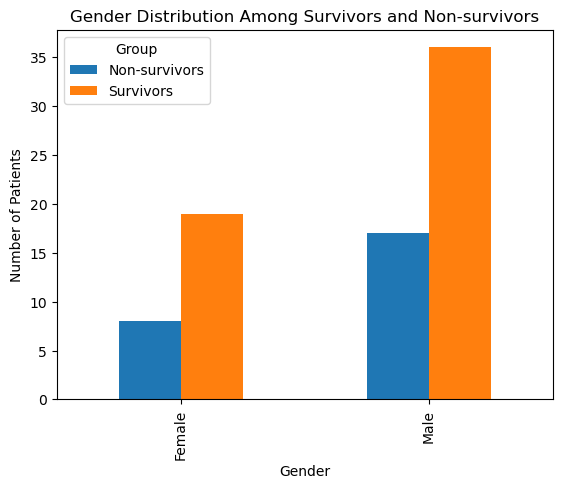

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame({
    'Group': ['Survivors', 'Survivors', 'Non-survivors', 'Non-survivors'],
    'Gender': ['Male', 'Female', 'Male', 'Female'],
    'Count': [36, 19, 17, 8]
})

pivot = data.pivot(index='Gender', columns='Group', values='Count')
pivot.plot(kind='bar')

plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.title('Gender Distribution Among Survivors and Non-survivors')
plt.show()


/var/folders/12/8lkj885d5ssgvh2ngd8t253c0000gn/T/ipykernel_57030/168356903.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ages.values(), labels=ages.keys())


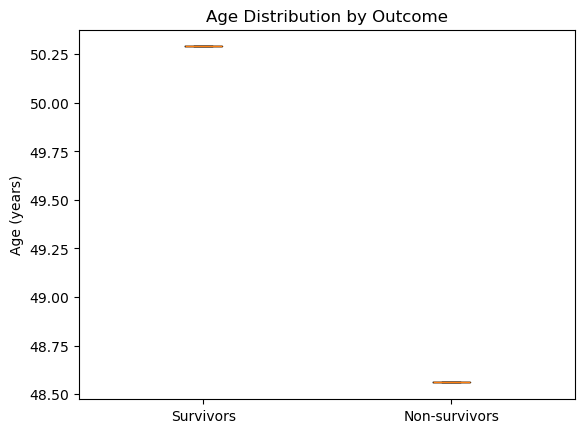

In [2]:
ages = {
    'Survivors': [50.29],
    'Non-survivors': [48.56]
}

plt.boxplot(ages.values(), labels=ages.keys())
plt.ylabel('Age (years)')
plt.title('Age Distribution by Outcome')
plt.show()


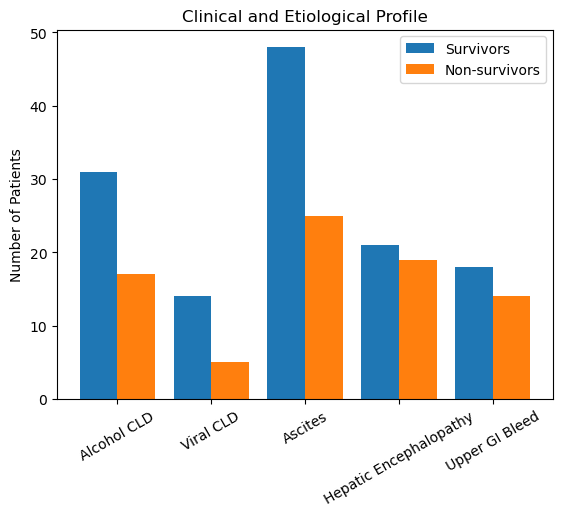

In [3]:
features = ['Alcohol CLD', 'Viral CLD', 'Ascites', 'Hepatic Encephalopathy', 'Upper GI Bleed']
survivors = [31, 14, 48, 21, 18]
nonsurvivors = [17, 5, 25, 19, 14]

x = range(len(features))

plt.bar(x, survivors, width=0.4, label='Survivors')
plt.bar([i + 0.4 for i in x], nonsurvivors, width=0.4, label='Non-survivors')

plt.xticks([i + 0.2 for i in x], features, rotation=30)
plt.ylabel('Number of Patients')
plt.title('Clinical and Etiological Profile')
plt.legend()
plt.show()


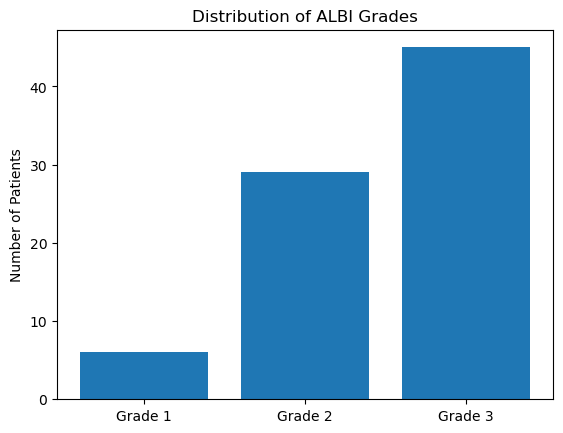

In [4]:
grades = ['Grade 1', 'Grade 2', 'Grade 3']
counts = [6, 29, 45]

plt.bar(grades, counts)
plt.ylabel('Number of Patients')
plt.title('Distribution of ALBI Grades')
plt.show()


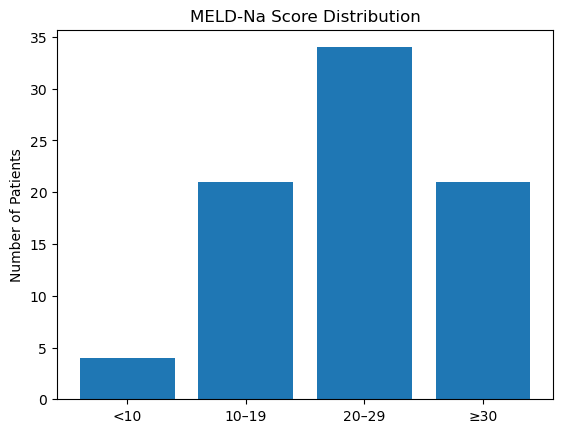

In [5]:
meld_cat = ['<10', '10–19', '20–29', '≥30']
counts = [4, 21, 34, 21]

plt.bar(meld_cat, counts)
plt.ylabel('Number of Patients')
plt.title('MELD-Na Score Distribution')
plt.show()


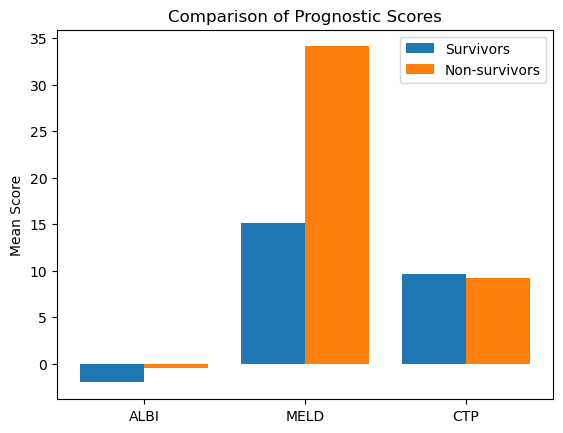

In [6]:
scores = ['ALBI', 'MELD', 'CTP']
survivors = [-2.03, 15.11, 9.64]
nonsurvivors = [-0.47, 34.11, 9.20]

x = range(len(scores))

plt.bar(x, survivors, width=0.4, label='Survivors')
plt.bar([i + 0.4 for i in x], nonsurvivors, width=0.4, label='Non-survivors')

plt.xticks([i + 0.2 for i in x], scores)
plt.ylabel('Mean Score')
plt.title('Comparison of Prognostic Scores')
plt.legend()
plt.show()


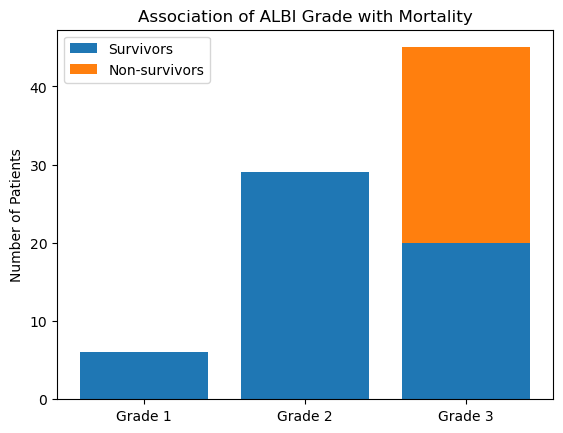

In [7]:
grades = ['Grade 1', 'Grade 2', 'Grade 3']
survivors = [6, 29, 20]
nonsurvivors = [0, 0, 25]

plt.bar(grades, survivors, label='Survivors')
plt.bar(grades, nonsurvivors, bottom=survivors, label='Non-survivors')

plt.ylabel('Number of Patients')
plt.title('Association of ALBI Grade with Mortality')
plt.legend()
plt.show()


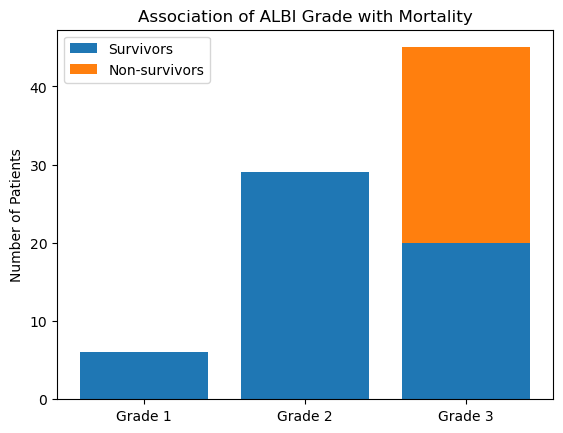

In [8]:
grades = ['Grade 1', 'Grade 2', 'Grade 3']
survivors = [6, 29, 20]
nonsurvivors = [0, 0, 25]

plt.bar(grades, survivors, label='Survivors')
plt.bar(grades, nonsurvivors, bottom=survivors, label='Non-survivors')

plt.ylabel('Number of Patients')
plt.title('Association of ALBI Grade with Mortality')
plt.legend()
plt.show()


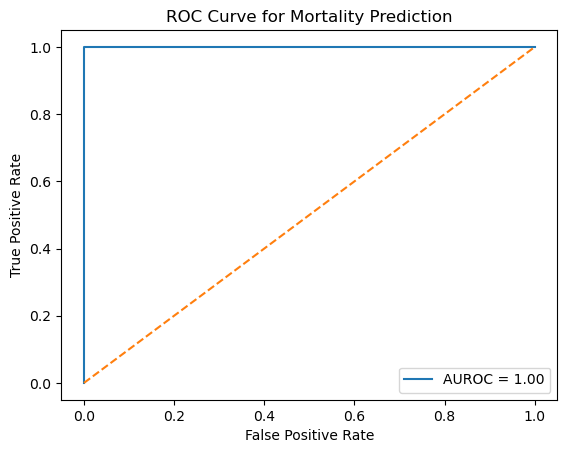

In [9]:
from sklearn.metrics import roc_curve, auc

# Perfect prediction example
y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.2, 0.9, 0.95]

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Mortality Prediction')
plt.legend()
plt.show()
